In [41]:
from collections import defaultdict
import dataclasses
from email.policy import default

import kneed
import numpy as np
import pandas as pd
import zipfile
import ast
import kmapper as km
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KDTree
from networkx.readwrite import json_graph
import networkx as nx
import json
import os
import itertools

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_moons, make_circles
from tqdm import tqdm
from dataclasses import dataclass

import matplotlib.pyplot as plt

In [15]:
class BallMapper:
    def __init__(self) -> None:
        pass

    def map(self, data: pd.DataFrame, epsilon: float):
        """
        Maps the data to a ball graph.

        Parameters
        ---------
        data: pd.DataFrame
            The data to map.
        epsilon: float
            The radius of the ball.
        """
        graph = {}

        coverage = [False] * len(data)
        nodes = dict()
        edges = set()

        # compute a KD-tree for fast radius search
        tree = KDTree(data, leaf_size=40)

        # iterate over all points
        for i in tqdm(range(len(data))):
            if not coverage[i]:
                # find all points in the ball
                neighbors = tree.query_radius([data.iloc[i]], r=epsilon)[0]

                # add the point to the graph
                nodes[i] = set(neighbors.tolist())

                # mark all points in the ball as covered
                for j in neighbors:
                    coverage[j] = True

                # mark the point as covered
                coverage[i] = True

        # iterate over all nodes
        for i in nodes:
            for j in nodes:
                if i != j and nodes[i].intersection(nodes[j]):
                    edges.add(tuple(sorted((i, j))))

        graph['nodes'] = {k: list(v) for k, v in nodes.items()}
        graph['links'] = {i: [j] for i, j in edges}

        return graph
        
def elbow_eps(data):
    n_neighbors = 5
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[::-1]
    kneedle = kneed.KneeLocator(distances[:, n_neighbors - 1], np.linspace(0, 1, num=len(distances)), curve='convex', direction='decreasing')
    # kneedle.plot_knee()
    eps = kneedle.knee
    return eps

100%|██████████| 4282/4282 [00:01<00:00, 3005.25it/s]


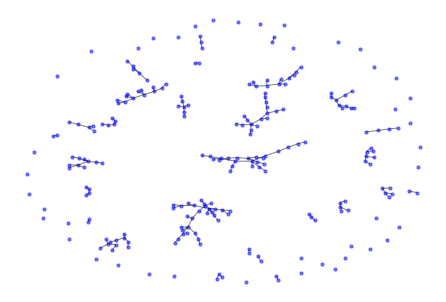

In [17]:
activations = pd.read_csv('../backend/data/ss-role/fine-tuned-bert-base-uncased/train/176/9.txt', delim_whitespace=True, header=None)
labels = pd.read_csv('../backend/data/ss-role/entities/train.txt', delim_whitespace=True, header=None)
X = activations
# plt.scatter(X.iloc[:, 0], X.iloc[:, 1])

bm = BallMapper()
graph = bm.map(X, epsilon=elbow_eps(X))

G = nx.Graph()
G.add_nodes_from(graph['nodes'])
G.add_edges_from([(k, v[0]) for k, v in graph['links'].items()])

pos = nx.spring_layout(G)
nx.draw(G, pos=pos, node_size=10, node_color='blue', edge_color='black', width=1, alpha=0.5)

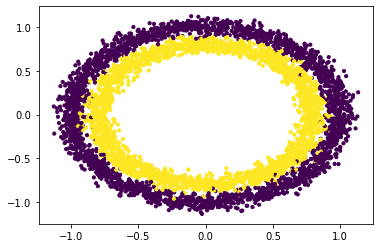

In [43]:
X, y = make_circles(n_samples=5000, noise=0.05)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10, c = y)


100%|██████████| 5000/5000 [00:00<00:00, 1249420.32it/s]


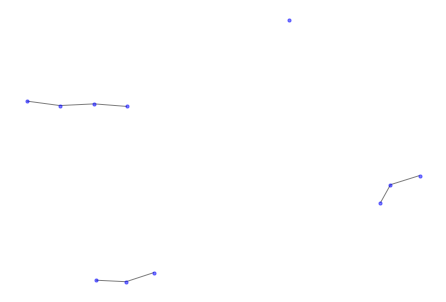

In [46]:
X = pd.DataFrame(X)
bm = BallMapper()
graph = bm.map(X, epsilon=0.5)

G = nx.Graph()
G.add_nodes_from(graph['nodes'])
G.add_edges_from([(k, v[0]) for k, v in graph['links'].items()])

pos = nx.spring_layout(G)
nx.draw(G, pos=pos, node_size=10, node_color='blue', edge_color='black', width=1, alpha=0.5)